Prepare the code

In [1]:
# Exam
import math
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile 
# from qiskit.compiler.assemble import assemble
# from qiskit.assembler.disassemble import disassemble
# %config InlineBackend.figure_format = 'svg' # Makes the images look nice
import matplotlib.pyplot as plt
import matplotlib


Control Panel

In [2]:
N = 3
Na = 0

Target = 0 #Target bit, 0<=traget<=N-1
Nc = N #nbr of classical bits
ns = 1 #1 = sim w/ noise, 2 = real device, else = sim
n_model = 0 #0 = model from backend, 1= depolarizing error
P = 0.2 #depolarizing probability

Implementation of the MCZ gate, Oracle and Iterator (and a function to create depolarization error)


In [3]:
def get_noise(p, qubits=1): #from: https://github.com/MIGUEL-LO/Qiskit_depolarazation_channel/blob/master/depo_channel_using_depolarizing_error.ipynb
    
    # This creates the depolarizing error channel,
    # epsilon(P) = (1-P)rho + (P/3)(XrhoX + YrhoY + ZrhoZ).
    depo_err_chan = depolarizing_error((4*p)/3, qubits)

    # Creating the noise model to be used during execution.
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depo_err_chan, "measure") # measurement error is applied to measurements

    return noise_model, depo_err_chan

def mcz(crct, n, na):
    ntot = n + na
    #todo: remplacer n, na dans les arguments par Cqubit (liste des indices de qubit de contrôle)
    #todo: pour l'instant le code prend en contrôle tous les autres qubits que le target
    if n > 4:
        #first ccnot gates
        crct.ccx(n-1,n-2, n)
        for i in range(n-2):
            crct.ccx(n-3-i,n+i, n+1+i)
        crct.cz(ntot-1,0) #controlled operation
        #second ccnot gates
        for i in range(n-2):
            crct.ccx(i,ntot-2-i, ntot-1-i)
        crct.ccx(n-1,n-2, n)
    else:
        mcz_alt(crct,n)

def mcz_alt(crct, n):
    if n==3:
        crct.h(0)
        crct.toffoli(1,2,0)
        crct.h(0)
    if n==1:
        crct.z(0)
    if n==2:
        crct.cz(0,1)
    if n==4:
        phi = pi/8
        crct.rz(phi,0)
        #====
        crct.cx(0,1)
        crct.rz(-phi,1)
        crct.cx(0,1)
        crct.rz(phi,1)
        #====
        crct.cx(1,2)
        crct.rz(-phi,2)
        crct.cx(0,2)
        crct.rz(phi,2)
        crct.cx(1,2)
        crct.rz(-phi,2)
        crct.cx(0,2)
        crct.rz(phi,2)
        #====
        crct.cx(2,3)
        crct.rz(-phi,3)
        crct.cx(0,3)
        crct.rz(phi,3)
        crct.cx(1,3)
        crct.rz(-phi,3)
        crct.cx(0,3)
        crct.rz(phi,3)
        crct.cx(2,3)
        crct.rz(-phi,3)
        crct.cx(0,3)
        crct.rz(phi,3)
        crct.cx(1,3)
        crct.rz(-phi,3)
        crct.cx(0,3)
        crct.rz(phi,3)

        # print(crct)



def Oracle(crct, trgt, n, na):
    #Oracle with 2 solutions
    if n == 3:
        if trgt == 0.6: #tragets = |000> and |101>
            for i in range(n):
                crct.z(i)
                crct.cz(0,1)
                crct.cz(1,2)
        if trgt == 0:
            for i in range(n):
                crct.x(i)

            crct.h(0)
            crct.toffoli(1,2,0)
            crct.h(0)
            for i in range(n):
                crct.x(i)
    else:
        #converting target into binary
        str = bin(trgt)
        #removing the header of the string (0b, as it is a binary string)
        str = str[2:]
        #length of the string
        l = len(str)
        #expanding str to length n (n qubits)
        if l < n:
            for k in range(n-l):
                str = '0' + str
        #inverting the string (using slice)
        str = str[::-1]
        #Implemeting the oracle
        for j in range(n-1,-1,-1):
            if str[j] == '0':
                crct.x(j)
        mcz(crct, n, na)
        for j in range(n-1,-1,-1):
            if str[j] == '0':
                crct.x(j)



def GroverIterator(crct, n, na, trgt):
    #Oracle
    Oracle(crct, trgt, n, na)
    #Hadamard
    for qubit in range(n):
        crct.h(qubit)
    #Conditional phase shift
    for qubit in range(n):
        crct.x(qubit)
    mcz(crct, n, na)
    for qubit in range(n):
        crct.x(qubit)

    #Hadamard
    for qubit in range(n):
        crct.h(qubit)


Core of the code

/home/rezad/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


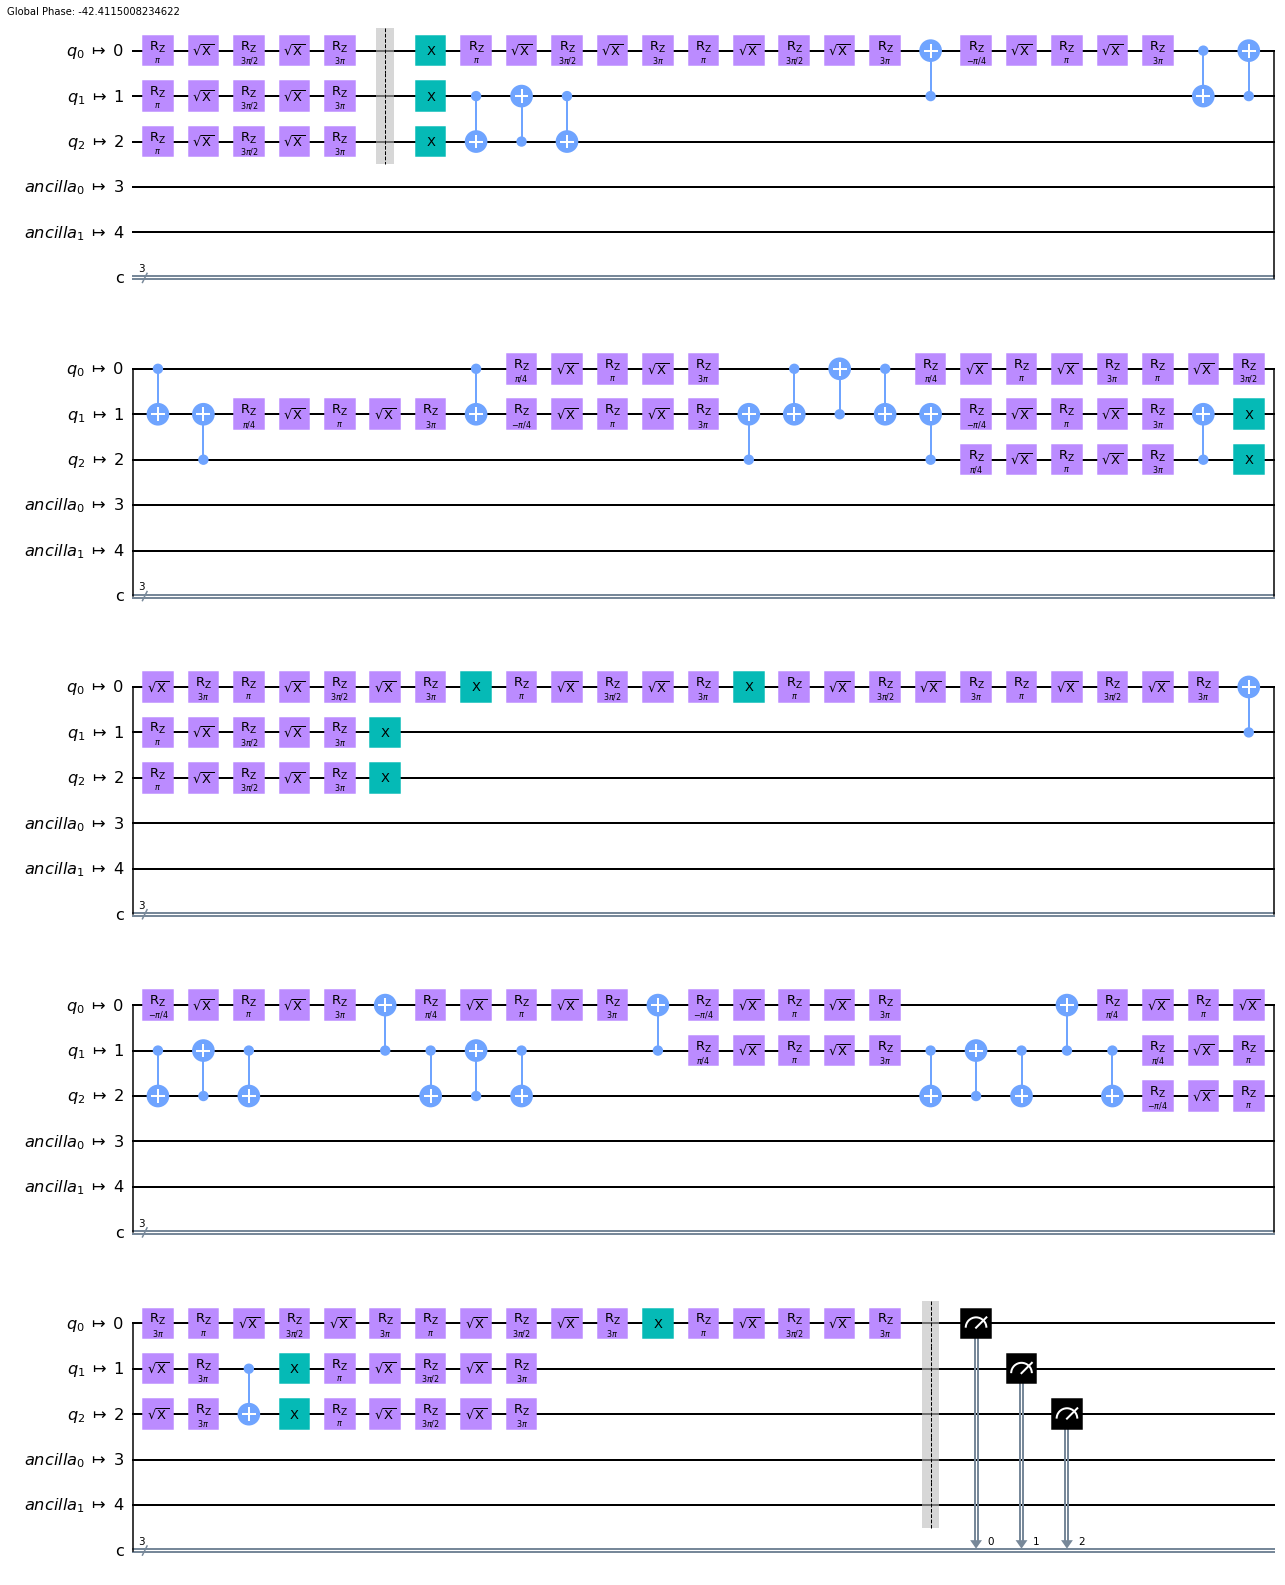

In [4]:
#Start of the circuit
grvr = QuantumCircuit(N+Na,Nc) #initializing

#Constructing the uniform superposition of states
for qubit in range(N):
    grvr.h(qubit)

grvr.barrier()

#Applying the Grover iterator
for repet in range(math.floor(math.sqrt(N))):
    GroverIterator(grvr, N, Na, Target)
    grvr.barrier()

for n in range(N):
    grvr.measure(n,n)

#visualization of the circuit
# print(grvr) #in the terminal
grvr.draw('mpl')

inst = grvr.data
#print(inst)

#Visualizing the compiled circuit 
provider         = IBMQ.load_account()
bcknd = provider.get_backend('ibmq_valencia')
comp_circ = transpile(grvr, bcknd)
#Printing the circuit
comp_circ.draw('mpl')

Running the circuit

In [5]:
#=== Results ===
#Getting the noise model
shots = 2048 #nbr of runs of the circuit

if ns == 1: #sim with noise
    provider         = IBMQ.load_account()

    backend          = provider.get_backend('ibmq_valencia')
    if n_model == 0:
        noise_model  = NoiseModel.from_backend(backend)
    else:
        noise_model, depo_err_chan = get_noise(P, 1)
    
    simulator        = Aer.get_backend('qasm_simulator')
    # results = execute(grvr, backend=simulator, shots=shots,noise_model = noise_model).result()
    results = execute(comp_circ, backend=simulator, shots=shots,noise_model = noise_model).result()
elif ns == 2: #real device
    provider         = IBMQ.load_account()
    backend         = provider.get_backend('ibmq_valencia')
    job = execute(grvr, backend = backend, shots = 1024, optimization_level= 3)
    job_monitor(job, interval= 2)
    results = job.result()

else: #sim
    backend = Aer.get_backend('qasm_simulator') #selection of the device on which to execute the circuit
    results = execute(grvr, backend = backend, shots = shots).result()
    
#Getting the results
answer = results.get_counts()

#ploting
plot_histogram(answer)
plt.show()


/home/rezad/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-01-18 09:34:38,485: Credentials are already in use. The existing account in the session will be replaced.


Getting the graphs